# Initialize

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
import io
import logging
import time

import matplotlib as mpl
params = {'axes.spines.right': False,
          'axes.spines.top': False,
          'legend.fontsize': 12,
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'pdf.fonttype': 42,
          'ps.fonttype': 42}
mpl.rcParams.update(params)

import matplotlib.pyplot as plt
import sys, importlib

import nems0.modelspec as ms
import nems0.xforms as xforms
import nems0.xform_helper as xhelp
from nems0.utils import escaped_split, escaped_join
import nems0.db as nd
from nems import get_setting
from nems0.xform_helper import _xform_exists, load_model_xform, fit_model_xform
from nems0.registry import KeywordRegistry, xforms_lib, keyword_lib
from nems0.plugins import (default_keywords, default_loaders,
                          default_initializers, default_fitters)
from nems_lbhb import baphy_experiment
from nems_lbhb.exacloud.queue_exacloud_job import enqueue_exacloud_models

log = logging.getLogger(__name__)

### Specify cell/batch/model

In [2]:
batch=328
cellid="ARM013b"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x100.g-fir.1x25x100-relu.100.f-wc.100x120-relu.120.f-wc.120xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname="ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x6.g-fir.1x25x6-relu.6.f-wc.6x1-lvl.1-dexp.1_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname="ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x80.g-fir.1x15x80-relu.80.f-wc.80x90-fir.1x10x90-relu.90.f-wc.90x120-relu.120-wc.120xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x80.g-fir.1x25x80-relu.80.f-wc.80x100-relu.100.f-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

batch=333
cellid="HOD007a"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
cellid="TBR008a"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4"

cellid="ALLCELLS"

modelname = "ozgf.fs100.ch18.pop-loadpop-norm.l1-sev_wc.18x90.g-fir.1x15x90-relu.90.f-wc.90x100-fir.1x10x100-relu.100.f-wc.100x160-relu.160-wc.160xR-lvl.R-dexp.R_tfinit.n.mc50.lr1e3.et4.es20-newtf.n.mc100.lr1e4"

batch=333
cellid="HOD005b-01-1"
modelname='ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4'


# fit_xforms_model code

high-level options

In [3]:
autoPlot = True
saveInDB = False
browse_results = False
saveFile = False

log.info('Initializing modelspec(s) for cell/batch %s/%d...', cellid, int(batch))

# Segment modelname for meta information
kws = modelname.split("_")
modelspecname = "-".join(kws[1:-1])
loadkey = kws[0]
fitkey = kws[-1]

meta = {'batch': batch, 'cellid': cellid, 'modelname': modelname,
        'loader': loadkey, 'fitkey': fitkey, 'modelspecname': modelspecname,
        'username': 'nems', 'labgroup': 'lbhb', 'public': 1,
        'githash': os.environ.get('CODEHASH', ''),
        'recording': loadkey}

[__main__ INFO] Initializing modelspec(s) for cell/batch HOD005b-01-1/333...


Generate xfspec

In [4]:
xforms_kwargs = {}
xforms_init_context = {'cellid': cellid, 'batch': int(batch)}
recording_uri = None
kw_kwargs ={}

# equivalent of xform_helper.generate_xforms_spec():

# parse modelname and assemble xfspecs for loader and fitter
load_keywords, model_keywords, fit_keywords = escaped_split(modelname, '_')

# Generate the xfspec, which defines the sequence of events
# to run through (like a packaged-up script)

# 0) set up initial context
if xforms_init_context is None:
    xforms_init_context = {}
if kw_kwargs is not None:
     xforms_init_context['kw_kwargs'] = kw_kwargs
xforms_init_context['keywordstring'] = model_keywords
xforms_init_context['meta'] = meta
xforms_lib.kwargs = xforms_init_context.copy()

xfspec = [['nems0.xforms.init_context', xforms_init_context]]

# 1) Load the data
xfspec.extend(xhelp._parse_kw_string(load_keywords, xforms_lib))

# 2) generate a modelspec
xfspec.append(['nems0.xforms.init_from_keywords', {'registry': keyword_lib}])

# 3) fit the data
xfspec.extend(xhelp._parse_kw_string(fit_keywords, xforms_lib))

# 4) add some performance statistics
if not _xform_exists(xfspec, 'nems0.xforms.predict'):
    xfspec.append(['nems0.xforms.predict', {}])

# 5) add some performance statistics (optional)
if not _xform_exists(xfspec, 'nems0.xforms.add_summary_statistics'):
    xfspec.append(['nems0.xforms.add_summary_statistics', {}])

# 6) generate plots (optional)
if autoPlot and not _xform_exists(xfspec, 'nems0.xforms.plot_summary'):
    xfspec.append(['nems0.xforms.plot_summary', {}])

[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/HOD005b_ffddbd8ba57a049bed7ac52746035ec2a4a97307.tgz


In [5]:
len(xfspec)
xfspec[1]

['nems0.xforms.init_context',
 {'recording_uri_list': ['/auto/data/nems_db/recordings/333/HOD005b_ffddbd8ba57a049bed7ac52746035ec2a4a97307.tgz'],
  'cellid': ['HOD005b-01-1']}]

equivalent of xforms.evaluate():

[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.xforms INFO] Extracting cellid(s) ['HOD005b-01-1']
[nems0.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems0.xforms INFO] Evaluating: nems0.xforms.normalize_sig
[nems0.xforms INFO] xforms.normalize_sig: stim b=0.0, g=5.441876601479855, dlog(..., -1)
[nems0.xforms INFO] Evaluating: nems0.xforms.normalize_sig
[nems0.xforms INFO] xforms.normalize_sig: resp b=0.0, g=6.0, dlog(..., -None)
[nems0.xforms INFO] Evaluating: nems0.xforms.split_by_occurrence_counts
[nems0.xforms INFO] Evaluating: nems0.xforms.average_away_stim_occurrences
[nems0.xforms INFO] Evaluating: nems0.xforms.init_from_keywords
[nems0.initializers INFO] kw: wc.18x70.g
[nems0.initializers INFO] kw: fir.1x15x70
[nems0.initia

Epoch 00001/10000 - loss: 69.5783 - pearson: 0.5607 - val_loss: 92.5661 - val_pearson: 0.3391
Epoch 00050/10000 - loss: 0.1851 - pearson: 0.8279 - val_loss: 0.3660 - val_pearson: 0.6843
Epoch 00100/10000 - loss: 0.1713 - pearson: 0.8436 - val_loss: 0.3445 - val_pearson: 0.7047
Epoch 00150/10000 - loss: 0.1613 - pearson: 0.8485 - val_loss: 0.3484 - val_pearson: 0.7154
Epoch 00200/10000 - loss: 0.1588 - pearson: 0.8507 - val_loss: 0.3623 - val_pearson: 0.7186
Epoch 00250/10000 - loss: 0.1620 - pearson: 0.8517 - val_loss: 0.3734 - val_pearson: 0.7246
Epoch 00300/10000 - loss: 0.1578 - pearson: 0.8515 - val_loss: 0.3417 - val_pearson: 0.7159


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 10 in modelspec_original


Restoring model weights from the end of the best epoch.
Epoch 00315: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 7.008142438214825e-09
[nems0.tf.cnnlink_new INFO] Initializing static nl "nems0.modules.nonlinearity.double_exponential" at layer #10
[nems0.initializers INFO] Init dexp: {'amplitude': array([[0.19167003]]), 'base': array([[-0.00754905]]), 'kappa': array([[0.]]), 'shift': array([[0.]])}
[nems0.tf.cnnlink_new INFO] Running second init fit: force_freeze: [0, 1, 2, 3, 4, 5, 6, 7].
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Special case of freezing: truncating model!!!
[nems0.tf.cnnlink_new INFO] Feature dimensions: (70, 200, 100); Data dimensions: (70, 200, 1).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.levelshift.levelshift".
[nems0.tf.layers INFO] Building tf layer for "nems0.mod

Epoch 00001/10000 - loss: 0.6192 - pearson: 0.8485 - val_loss: 1.0207 - val_pearson: 0.7205
Epoch 00050/10000 - loss: 0.2501 - pearson: 0.7599 - val_loss: 0.3850 - val_pearson: 0.6430
Epoch 00100/10000 - loss: 0.2029 - pearson: 0.8076 - val_loss: 0.3272 - val_pearson: 0.7052
Epoch 00150/10000 - loss: 0.1735 - pearson: 0.8365 - val_loss: 0.3038 - val_pearson: 0.7334
Epoch 00200/10000 - loss: 0.1587 - pearson: 0.8502 - val_loss: 0.2967 - val_pearson: 0.7459
Epoch 00250/10000 - loss: 0.1533 - pearson: 0.8562 - val_loss: 0.2967 - val_pearson: 0.7520
Epoch 00300/10000 - loss: 0.1509 - pearson: 0.8568 - val_loss: 0.2927 - val_pearson: 0.7561
Epoch 00350/10000 - loss: 0.1500 - pearson: 0.8593 - val_loss: 0.2894 - val_pearson: 0.7586
Epoch 00400/10000 - loss: 0.1497 - pearson: 0.8580 - val_loss: 0.2851 - val_pearson: 0.7601
Epoch 00450/10000 - loss: 0.1491 - pearson: 0.8598 - val_loss: 0.2875 - val_pearson: 0.7615
Epoch 00500/10000 - loss: 0.1478 - pearson: 0.8612 - val_loss: 0.2847 - val_pear

[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic_1 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_1 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 11 in modelspec_original


Restoring model weights from the end of the best epoch.
Epoch 00834: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 8.701973369464051e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.fit_wrapper
[nems0.xforms INFO] ----------------------------------------------------
[nems0.xforms INFO] Fitting: nems0.tf.cnnlink_new.fit_tf, fit 1/1, fold 1/1
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Special case of freezing: truncating model!!!
[nems0.tf.cnnlink_new INFO] Feature dimensions: (70, 200, 100); Data dimensions: (70, 200, 1).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.levelshift.levelshift".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.nonlinearity.double_exponential".
[nems0.tf.modelbuilder INFO] Built model, printing summary.
[nems0.tf.modelbuilder INFO] Model: "Test-model"
[nems

Epoch 00001/10000 - loss: 0.1668 - pearson: 0.8386
Epoch 00050/10000 - loss: 0.1647 - pearson: 0.8618
Epoch 00100/10000 - loss: 0.1615 - pearson: 0.8602
Epoch 00150/10000 - loss: 0.1607 - pearson: 0.8531
Epoch 00200/10000 - loss: 0.1611 - pearson: 0.8543
Epoch 00250/10000 - loss: 0.1607 - pearson: 0.8454
Epoch 00300/10000 - loss: 0.1609 - pearson: 0.8572
Epoch 00350/10000 - loss: 0.1604 - pearson: 0.8547
Restoring model weights from the end of the best epoch.
Epoch 00358: early stopping


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic_2 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_2 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_1 to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 11 in modelspec_original
[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 8.643541731061816e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.predict
[nems0.xforms INFO] Evaluating: nems0.xforms.add_summary_statistics
[nems0.xforms INFO] cell_index: 0
[nems0.xforms INFO] Evaluating: nems0.xforms.plot_summary
[nems0.modelspec INFO] Quickplot: no epoch specified, falling back to "REFERENCE"
[nems0.modelspec INFO] plotting row 1/7
[nems0.modelspec INFO] plotting row 2/7
[nems0.modelspec INFO] plotting row 3/7
[nems0.modelspec INFO] plotting row 4/7
[n

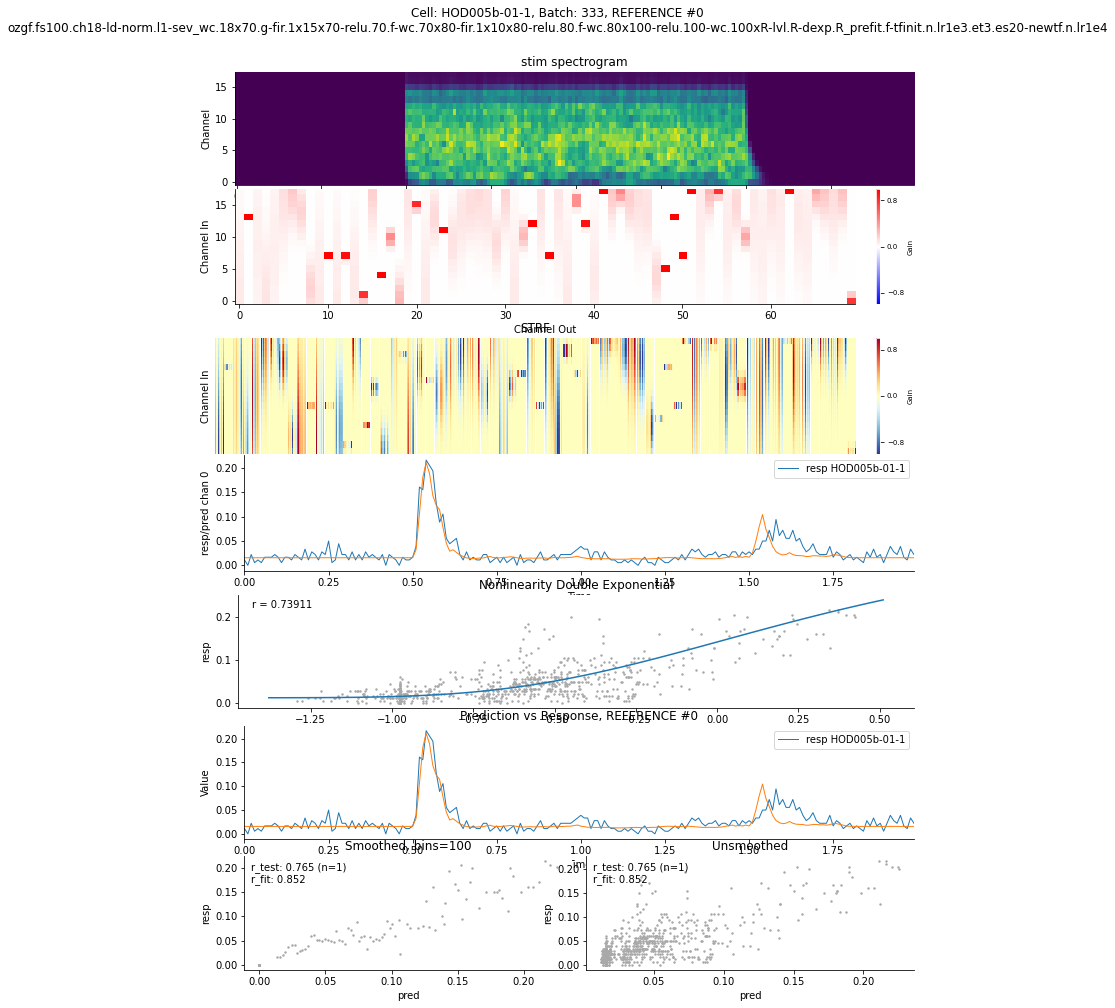

In [6]:
starttime=time.time()
# Create a log stream set to the debug level; add it as a root log handler
log_stream = io.StringIO()
ch = logging.StreamHandler(log_stream)
ch.setLevel(logging.DEBUG)
fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
formatter = logging.Formatter(fmt)
ch.setFormatter(formatter)
rootlogger = logging.getLogger()
rootlogger.addHandler(ch)

ctx = {}
for xfa in xfspec:
    if not('postprocess' in xfa[0]):
        ctx = xforms.evaluate_step(xfa, ctx)

# Close the log, remove the handler, and add the 'log' string to context
log.info('Done (re-)evaluating xforms.')
ch.close()
rootlogger.removeFilter(ch)

log_xf = log_stream.getvalue()

In [26]:
ctx['modelspec'].cell_index=2
ctx['modelspec'].cell_index, ctx['modelspec'].meta['r_test'].mean()

(2, 0.4722765082149491)

In [20]:
ctx['val_list'][2]['pred'].shape

(15, 1200)

In [15]:
ctx['modelspec'].fit_index=2
ctx['modelspec'].fit_index, ctx['modelspec'].meta['r_test'].mean(), ctx['modelspec'].meta['cellids'][:2]

(2, 0.5151746014041032, ['HOD005b-01-1', 'HOD005b-01-2'])

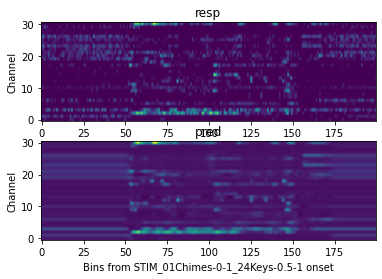

In [42]:
f,ax=plt.subplots(2,1)
ctx['est']['resp'].plot_epoch_avg('STIM_01Chimes-0-1_24Keys-0.5-1', ax=ax[0])
ctx['est']['pred'].plot_epoch_avg('STIM_01Chimes-0-1_24Keys-0.5-1', ax=ax[1])


In [48]:
ctx['modelspec'].meta['r_test'].mean()  #, ctx['modelspec'].meta['cellids']

0.3908738722088035

# Fit modelname2

[nems0.xform_helper INFO] Initializing modelspec(s) for cell/batch TBR008a/333...
[nems0.xform_helper INFO] TODO: simplify generate_xforms_spec parameters
[nems0.xform_helper INFO] Initializing modelspec(s) for recording/model None/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4...
[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/TBR008a_67d10ac6c9689303e2891d6fc3b075efb8d07a70.tgz
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.xforms INFO] Extracting cellid(s) ['TBR008a-05-5', 'TBR008a-08-4', 'TBR008a-09-1', 'TBR008a-12-1'

Epoch 00001/10000 - loss: 62.1138 - pearson: 0.0736 - val_loss: 45.3646 - val_pearson: 0.1050
Epoch 00050/10000 - loss: 0.5480 - pearson: 0.5973 - val_loss: 0.5850 - val_pearson: 0.5441
Epoch 00100/10000 - loss: 0.5079 - pearson: 0.6085 - val_loss: 0.5629 - val_pearson: 0.5678
Epoch 00150/10000 - loss: 0.4903 - pearson: 0.6403 - val_loss: 0.5765 - val_pearson: 0.5581
Epoch 00200/10000 - loss: 0.4717 - pearson: 0.6739 - val_loss: 0.6089 - val_pearson: 0.5351
Epoch 00250/10000 - loss: 0.4564 - pearson: 0.7056 - val_loss: 0.5707 - val_pearson: 0.5707
Restoring model weights from the end of the best epoch.
Epoch 00262: early stopping


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian to modelspec phis.
[nems0.tf.layers INFO] Converted fir to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_9 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_1 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_10 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_2 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_11 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_9 to modelspec phis.
[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 4.222648007607044e-09
[nems0.tf.cnnlink_new INFO] Initializing static nl "nems0.modules.nonlinearity.double_exponential" at layer #10
[nems0.initializers INFO] Init dexp completed for 31 channels 
[nems0.tf.cnnlink_new INFO] Running second init fit: not frozen but coarser tolerance.
[nems0.tf.cnnlink_ne

Epoch 00001/10000 - loss: 0.8652 - pearson: 0.3822 - val_loss: 0.7713 - val_pearson: 0.4170
Epoch 00050/10000 - loss: 0.5479 - pearson: 0.5880 - val_loss: 0.5673 - val_pearson: 0.5596
Epoch 00100/10000 - loss: 0.5192 - pearson: 0.6003 - val_loss: 0.5501 - val_pearson: 0.5790
Epoch 00150/10000 - loss: 0.5011 - pearson: 0.6321 - val_loss: 0.5533 - val_pearson: 0.5754
Epoch 00200/10000 - loss: 0.4777 - pearson: 0.6587 - val_loss: 0.5576 - val_pearson: 0.5709
Epoch 00250/10000 - loss: 0.4564 - pearson: 0.6971 - val_loss: 0.5512 - val_pearson: 0.5801
Epoch 00300/10000 - loss: 0.4386 - pearson: 0.6217 - val_loss: 0.5529 - val_pearson: 0.5756


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian_1 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_2 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_12 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_3 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_13 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_5 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_14 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_10 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_6 to modelspec phis.


Restoring model weights from the end of the best epoch.
Epoch 00336: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 3.809460620432857e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.fit_wrapper
[nems0.xforms INFO] ----------------------------------------------------
[nems0.xforms INFO] Fitting: nems0.tf.cnnlink_new.fit_tf, fit 1/1, fold 1/1
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Feature dimensions: (43, 200, 18); Data dimensions: (43, 200, 31).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.gaussian".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.fir.filter_bank".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.nonlinearity.relu".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.fir.filter_bank".
[nems0.tf.layers INFO] Building tf layer fo

Epoch 00001/10000 - loss: 0.4932 - pearson: 0.6435
Epoch 00050/10000 - loss: 0.4840 - pearson: 0.6420
Epoch 00100/10000 - loss: 0.4807 - pearson: 0.6611
Epoch 00150/10000 - loss: 0.4754 - pearson: 0.6666
Epoch 00200/10000 - loss: 0.4711 - pearson: 0.6546
Epoch 00250/10000 - loss: 0.4678 - pearson: 0.6622
Epoch 00300/10000 - loss: 0.4643 - pearson: 0.6587
Epoch 00350/10000 - loss: 0.4608 - pearson: 0.6687
Epoch 00400/10000 - loss: 0.4591 - pearson: 0.6836
Epoch 00450/10000 - loss: 0.4549 - pearson: 0.6708
Epoch 00500/10000 - loss: 0.4517 - pearson: 0.6634
Epoch 00550/10000 - loss: 0.4486 - pearson: 0.6866
Epoch 00600/10000 - loss: 0.4470 - pearson: 0.6638
Epoch 00650/10000 - loss: 0.4434 - pearson: 0.6775
Epoch 00700/10000 - loss: 0.4437 - pearson: 0.6997
Epoch 00750/10000 - loss: 0.4373 - pearson: 0.6879
Epoch 00800/10000 - loss: 0.4357 - pearson: 0.6978
Epoch 00850/10000 - loss: 0.4309 - pearson: 0.7048
Epoch 00900/10000 - loss: 0.4323 - pearson: 0.7065
Epoch 00950/10000 - loss: 0.427

[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian_2 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_4 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_15 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_5 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_16 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_8 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_17 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_11 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_7 to modelspec phis.


Restoring model weights from the end of the best epoch.
Epoch 02262: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 9.75774164544199e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.predict
[nems0.xforms INFO] Evaluating: nems0.xforms.add_summary_statistics
[nems0.xforms INFO] cell_index: 0
[nems0.xforms INFO] Evaluating: nems0.xforms.plot_summary
[nems0.modelspec INFO] Quickplot: no epoch specified, falling back to "REFERENCE"
[nems0.modelspec INFO] plotting row 1/7
[nems0.modelspec INFO] plotting row 2/7
[nems0.modelspec INFO] plotting row 3/7
[nems0.modelspec INFO] plotting row 4/7
[nems0.modelspec INFO] plotting row 5/7
[nems0.plots.scatter WARNING] corr coef expects single-dim predictions
[nems0.plots.scatter WARNING] sig1 or sig2 chancount > 1, using chan 0
[nems0.modelspec INFO] plotting row 6/7
[nems0.modelspec INFO] plotting row 7/7
[nems0.plots.scatter WARNING] sig1 or sig2 chancount > 1, using chan 0
[nems0.modelspec INFO] Quickplot: generated fig with title "Cell: TBR008a, Batch: 333, REFERENCE #0 ozgf.fs10

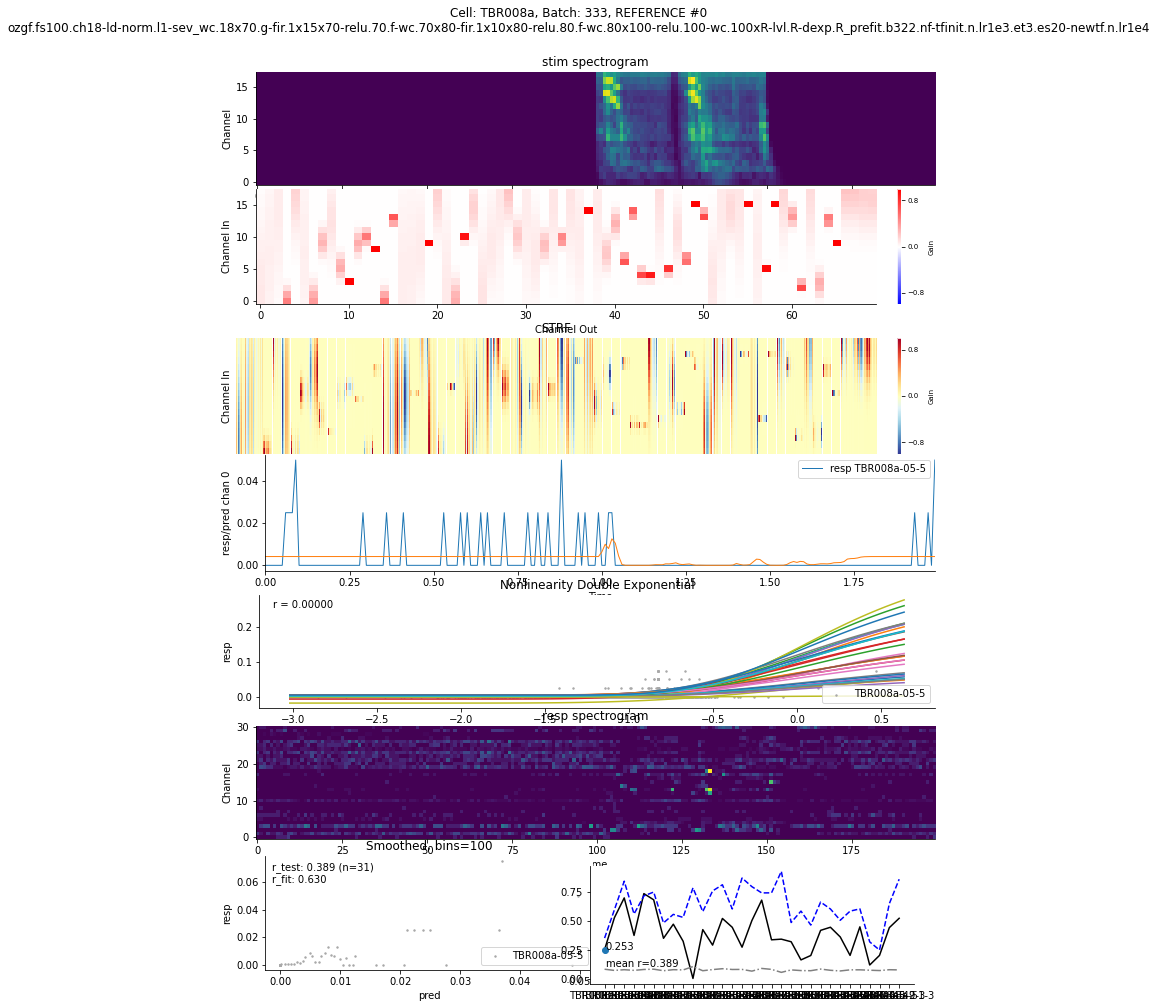

In [31]:
cellid="TBR008a"
modelname2 = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

xfspec2, ctx2=fit_model_xform(cellid, batch, modelname2, returnModel=True)

In [45]:
ctx2['modelspec'].meta['r_test'].mean()  #, ctx2['modelspec'].meta['cellids']

0.38947379673596755

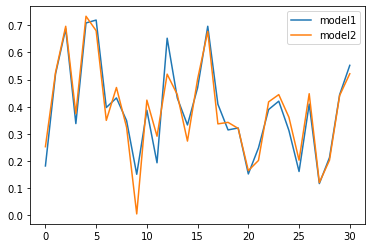

In [44]:
plt.figure()
plt.plot(ctx['modelspec'].meta['r_test'],label='model1')
plt.plot(ctx2['modelspec'].meta['r_test'],label='model2')
plt.legend()

# pooled OLP

In [7]:
from nems_lbhb.projects.pop_model_scripts.pop_model_utils import load_string_pop, fit_string_pop, load_string_single, fit_string_single,\
    POP_MODELS, SIG_TEST_MODELS, shortnames, shortnamesp, ALL_FAMILY_MODELS, ALL_FAMILY_POP, get_significant_cells


force_rerun = False
lbhb_user="svd"

# exacloud settings:
executable_path_exa = '/home/users/davids/anaconda3/envs/nems/bin/python'
script_path_exa = '/home/users/davids/nems/scripts/fit_single.py'
ssh_key = '/home/svd/.ssh/id_rsa'
user = "davids"

batch = 333
executable_path = '/auto/users/svd/bin/miniconda3/envs/tfg/bin/python'
script_path = '/auto/users/svd/python/nems/scripts/fit_single.py'


In [8]:
fit_string_single

'prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4'

In [9]:

ln_single_models = [f"{load_string_single}_wc.18x{rank}.g-fir.{rank}x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4"
                    for rank in range(1,5)]

# parameters for adding to queue
modelname_filter=ln_single_models[3]

fit_string_titan = "tfinit.n.mc25.lr1e3.es20-newtf.n.mc100.lr1e4.exa"
fit_string_titan = "tfinit.n.mc25.lr1e3.es20-newtf.n.mc50.lr1e4.exa"
fit_string_titan = "tfinit.n.mc50.lr1e3.es20-newtf.n.mc100.lr1e4.exa"
fit_string_titan = "tfinit.n.mc50.lr1e3.et4.es20-newtf.n.mc100.lr1e4"

# TITAN_MODELS: round 1, fit using cellid="ALLCELLS" on exacloud
TITAN_MODELS = [
    f"{load_string_pop}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_titan}", # c1dx2+d
]

# POP_MODELS: round 1, fit using cellid="<siteid>" on exacloud
CONTROL_MODELS = [
    f"{load_string_single}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_pop}", # c1dx2+d
]
CONTROL_SINGLE = [
    f"{load_string_single}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_single}", # c1dx2+d
]
CONTROL_SINGLE

['ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4']

In [29]:
#cellids = nd.get_batch_cells(batch=batch).cellid.to_list()
cellids = nd.batch_comp(modelnames=[modelname_filter], batch=batch).index.to_list()
siteids, _ = nd.get_batch_sites(batch, modelname_filter=modelname_filter)
len(siteids), siteids[:10],len(cellids), cellids[:10],modelname_filter

(27,
 ['HOD005b',
  'HOD006b',
  'HOD007a',
  'HOD008d',
  'HOD009a',
  'TBR007a',
  'TBR008a',
  'TBR009a',
  'TBR010a',
  'TBR011a'],
 655,
 ['HOD005b-01-1',
  'HOD005b-07-1',
  'HOD005b-04-1',
  'HOD005b-30-2',
  'HOD005b-39-1',
  'HOD005b-22-2',
  'HOD005b-03-1',
  'HOD007a-10-1',
  'HOD005b-17-1',
  'HOD005b-02-1'],
 'ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x4.g-fir.4x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4')

In [30]:
cellids = nd.batch_comp(modelnames=[modelname_filter], batch=batch).index.to_list()


In [26]:
modelname_filter

'ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x4.g-fir.4x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4'

In [31]:
# single-cell models -- CPU
#  ln_single_models[3:],
enqueue_exacloud_models(
        cellist=cellids, batch=batch, modellist=CONTROL_SINGLE, 
        user=lbhb_user, linux_user=user, force_rerun=force_rerun, 
        executable_path=executable_path_exa, script_path=script_path_exa, useGPU=False)

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-01-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-07-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-04-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-30-2/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-re

In [21]:
# pop models -- GPU
enqueue_exacloud_models(
        cellist=siteids, batch=batch, modellist=CONTROL_MODELS,
        user=lbhb_user, linux_user=user, force_rerun=force_rerun, 
        executable_path=executable_path_exa, script_path=script_path_exa, useGPU=True)

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD006b/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD007a/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD008d/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-rel

In [7]:

rec.signals.keys()

NameError: name 'rec' is not defined

In [5]:
cellid='TBR011a-16-1'
batch=333
loadkey='ozgf.fs100.ch18'
ex=baphy_experiment.BAPHYExperiment(cellid=cellid,batch=batch)
rec=ex.get_recording(loadkey=loadkey)

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[nems_lbhb.baphy_io INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/TBR011a_0a09b86c7349dce175a96da5ede9d2c11816663a.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


In [10]:
xf,ctx=load_model_xform(cellid=cellid,batch=batch,modelname=CONTROL_SINGLE[0])

[nems0.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/333/TBR011a-16-1/ozgf.fs100.ch18-ld-norm.l1-sev.wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x1...7014654012419247314 ...
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/333/TBR011a_0a09b86c7349dce175a96da5ede9d2c11816663a.tgz to /auto/data/nems_db/recordings/333/TBR011a_0a09b86c7349dce175a96da5ede9d2c11816663a.tgz
[nems0.xforms INFO] Extracting cellid(s) ['TBR011a-16-1']
[nems0.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems0.xforms INFO] Evaluating: nems0.xforms.normalize_sig
[nems0.xforms INFO] xforms.normalize_sig: stim b=0.0, g=5.869666561900331, dlog(..., -1)
[nems0.xforms INFO

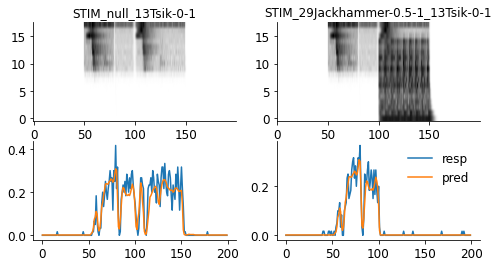

In [13]:
f,ax=plt.subplots(2,2, figsize=(8,4))

epoch="STIM_null_13Tsik-0-1"
s=ctx['val']['stim'].extract_epoch(epoch)
r=ctx['val']['resp'].extract_epoch(epoch)
p=ctx['val']['pred'].extract_epoch(epoch)

ax[0,0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,0].set_title(epoch)
ax[1,0].plot(r[0,0,:],label='resp')
ax[1,0].plot(p[0,0,:],label='pred')

epoch="STIM_29Jackhammer-0.5-1_13Tsik-0-1"
s=ctx['est']['stim'].extract_epoch(epoch)
r=ctx['est']['resp'].extract_epoch(epoch)
p=ctx['est']['pred'].extract_epoch(epoch)

ax[0,1].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,1].set_title(epoch)
ax[1,1].plot(r[0,0,:],label='resp')
ax[1,1].plot(p[0,0,:],label='pred')
ax[1,1].legend(frameon=False)

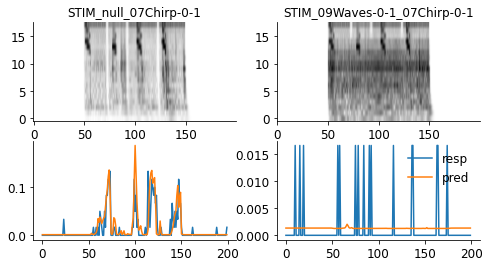

In [16]:
f,ax=plt.subplots(2,2, figsize=(8,4))

epoch="STIM_null_07Chirp-0-1"
s=ctx['val']['stim'].extract_epoch(epoch)
r=ctx['val']['resp'].extract_epoch(epoch)
p=ctx['val']['pred'].extract_epoch(epoch)

ax[0,0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,0].set_title(epoch)
ax[1,0].plot(r[0,0,:],label='resp')
ax[1,0].plot(p[0,0,:],label='pred')

epoch="STIM_09Waves-0-1_07Chirp-0-1"
s=ctx['est']['stim'].extract_epoch(epoch)
r=ctx['est']['resp'].extract_epoch(epoch)
p=ctx['est']['pred'].extract_epoch(epoch)

ax[0,1].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,1].set_title(epoch)
ax[1,1].plot(r[0,0,:],label='resp')
ax[1,1].plot(p[0,0,:],label='pred')
ax[1,1].legend(frameon=False)

In [12]:
ax[0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[1].plot(r[0,0,:],label='resp')
ax[1].plot(p[0,0,:],label='pred')

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'